<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
pip install sklearn-lvq

In [188]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [189]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [190]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('horas', color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('radiación solar', color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [191]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 7',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

In [192]:
def print_patrones(list_series,list_categorias,list_patrones,title_,namefile_): 
    cat = np.unique(list_categorias)
    n = math.ceil(pow(n_clusters, 0.5))
    fig, axs = plt.subplots(n, n, figsize=(15,14))
    row=0; col=0
    for c in cat:
        j = 0
        for g in list_categorias:    
            if c == g:
                axs[row,col].plot(list_series[j],alpha=0.5)
                axs[row,col].set_title(title_+str(c))
                #axs[row,col].xaxis.set_xlabel(horas_invierno)
            j = j + 1
        if len(list_patrones) != 0:
            axs[row, col].plot(list_patrones[c],alpha=0.7,color='red',linestyle='dashed',linewidth=4)
        col = col + 1
        if col == n:
            col = 0
            row = row + 1  
    plt.savefig(namefile_, transparent=True)
    plt.show()

# **Leemos datos fotovoltaicos**

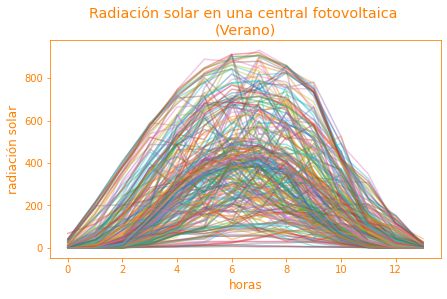

In [193]:
df = pd.read_csv('rg1_horas.csv')

##totales por dia ('SUMA'), diferenciados de primer orden ('dSUMA'), de segundo orden ('ddSUMA')
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

## Por estación del año
df_invierno = df[(df.MONTH==11)|(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)|(df.MONTH==3)|(df.MONTH==4)]
df_verano   = df[(df.MONTH==5) |(df.MONTH==6) |(df.MONTH==7)|(df.MONTH==8)|(df.MONTH==9)|(df.MONTH==10)]
df = df_invierno
horas_verano   = ['4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
horas_invierno = ['5','6','7','8','9','10','11','12','13','14','15','16','17','18']
X = df[horas_invierno].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X  = sc.fit_transform(X)
#y  = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.3)

print_serie(X_train,'Radiación solar en una central fotovoltaica \n(Verano)',False,'fig_t13_all')

# **K-means**


y_kmeans [6 4 6 9 6 8 9 6 5 0 8 3 2 3 6 8 3 6 8 8 8 5 3 9 0 3 7 4 8 8 8 3 3 9 9 8 5
 3 4 2 4 4 4 9 6 6 1 4 3 3 4 8 3 3 5 2 4 0 3 9 2 0 5 3 1 6 3 6 3 9 1 0 1 3
 4 3 1 4 9 5 0 4 0 7 8 5 8 2 0 5 9 4 3 7 9 6 9 3 4 2 0 9 1 9 4 1 4 3] 108
y_kmeans_train [6 1 9 7 1 3 3 3 8 7 1 3 3 4 8 3 8 6 8 3 3 6 9 4 0 6 2 3 6 5 6 3 1 1 0 4 3
 4 0 5 3 3 7 4 3 3 9 8 9 9 2 9 9 6 8 6 6 9 9 3 3 9 3 6 0 7 5 9 8 4 1 2 0 8
 7 3 3 1 4 0 1 1 8 4 6 2 0 6 3 7 9 5 9 9 3 4 5 6 0 6 8 8 9 0 3 1 6 9 3 6 3
 5 9 6 8 1 1 3 1 3 5 6 6 6 8 4 6 3 7 8 1 4 1 1 3 1 3 9 7 5 7 1 4 6 7 4 8 4
 5 2 3 9 3 2 4 2 5 8 4 3 3 1 4 0 9 1 9 6 8 1 7 7 8 3 5 5 8 6 1 1 9 4 0 2 2
 4 7 3 4 1 8 7 2 0 3 8 0 6 2 0 4 0 8 6 1 3 9 3 6 4 8 9 5 6 9 4 0 4 4 3 1 8
 9 1 3 6 9 6 6 6 3 2 3 7 1 5 1 8 3 8 3 8 1 5 4 8 3 8 5 4 7 3] 252


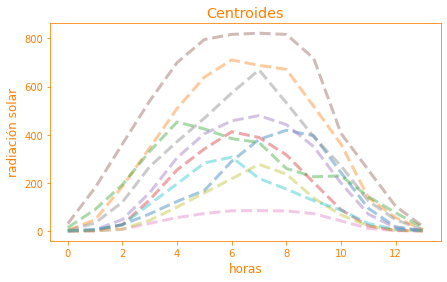

In [194]:
n_clusters = 10
k_means = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans, KMeans
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
kmeans_centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_kmeans = k_means.predict(X_test)
y_kmeans_train = k_means.predict(X_train)
print('y_kmeans' , y_kmeans,len(y_kmeans ))
print('y_kmeans_train' , y_kmeans_train,len(y_kmeans_train))
print_serie(kmeans_centers_,'Centroides',True,'fig_t13_centroids_kmeans')
#scatterplot(X_train[:,4],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')

X_train (kmeans)


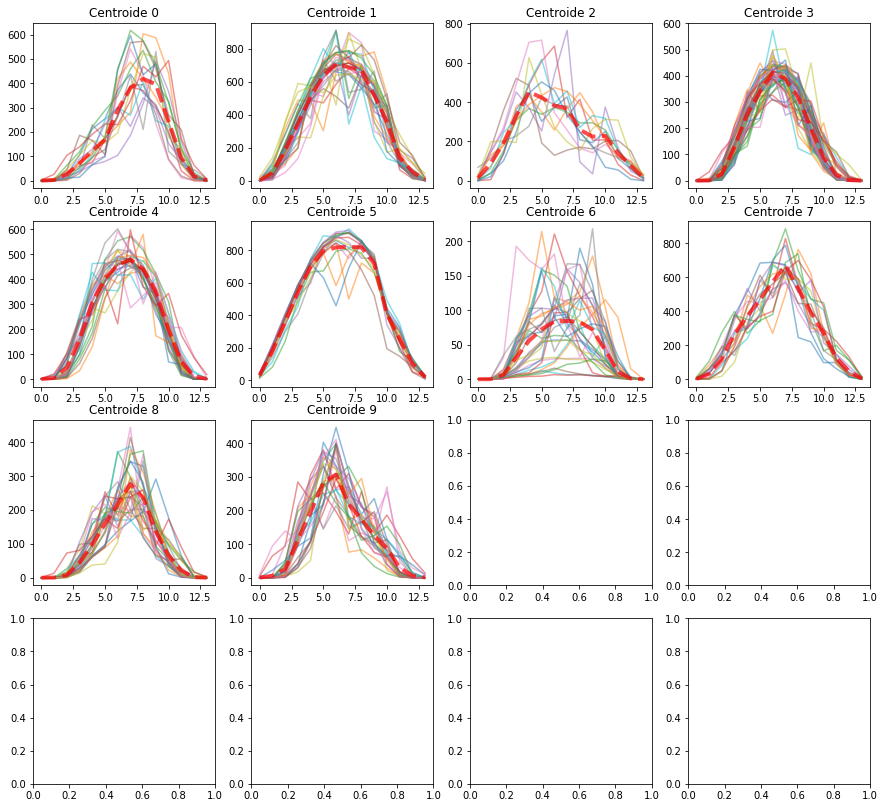

In [195]:
print('X_train (kmeans)')
print_patrones(list_series=X_train,list_categorias=y_kmeans_train,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_kmeans_train')

X_test (kmeans)


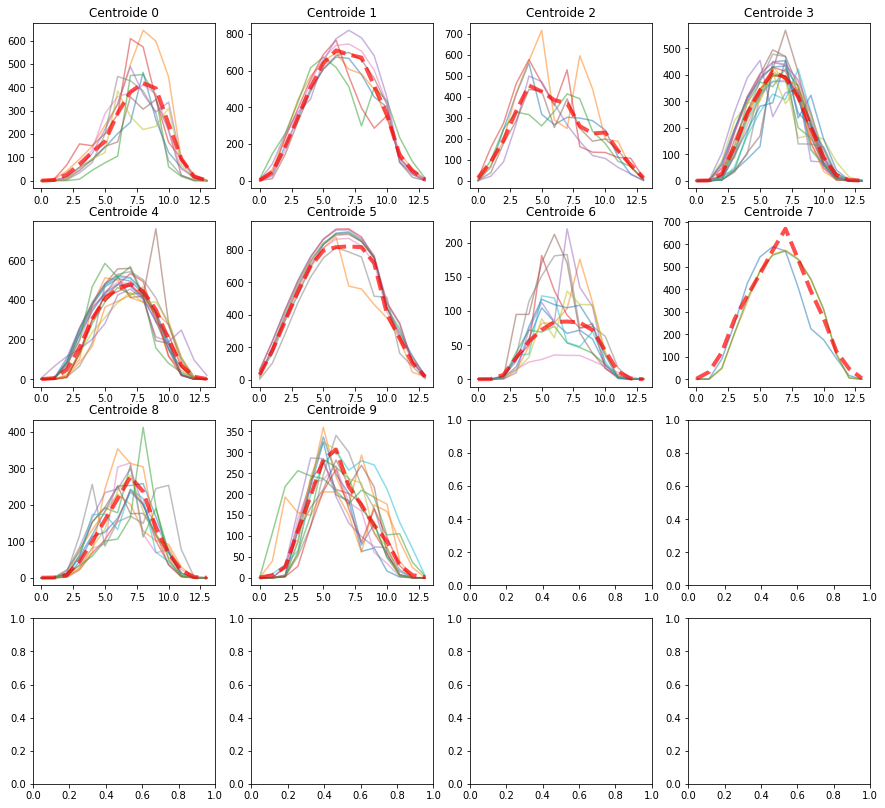

In [196]:
print('X_test (kmeans)')
print_patrones(list_series=X_test,list_categorias=y_kmeans,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_kmeans_test')

# **KNN from scratch**


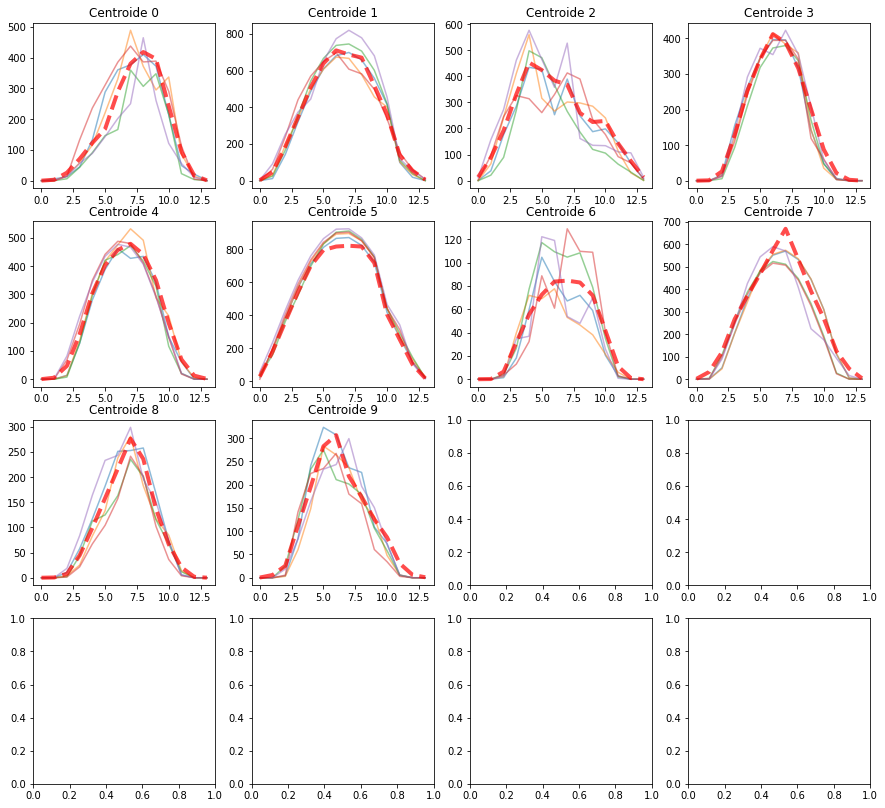

In [197]:
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
def euclidean(row1, row2):
	  distance = 0.0
	  for i in range(len(row1)-1):
		    distance += (row1[i] - row2[i])**2
	  return sqrt(distance)
   
dataset = [[2.7810836,2.550537003,0],	[1.465489372,2.362125076,0],	[3.396561688,4.400293529,0],	[1.38807019,1.850220317,0],[3.06407232,3.005305973,0],	[7.627531214,2.759262235,1],	[5.332441248,2.088626775,1],	[6.922596716,1.77106367,1],	[8.675418651,-0.242068655,1],[7.673756466,3.508563011,1]]

row0 = dataset[0]
#for row in dataset:
#	  distance = euclidean(row0, row)
#	  print(distance)
	 
## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors):
  
    distances = list()

    for train_row in train:
        dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	  neighbors = get_neighbors(train, test_row, num_neighbors)
	  output_values = [row[-1] for row in neighbors]
	  prediction = max(set(output_values), key=output_values.count)
	  return prediction

prediction = predict_classification(dataset, dataset[0], 3)

#neighbors = get_neighbors(dataset, dataset[0], 5)
serie = []
cat   = []
i     = 0 
for center in kmeans_centers_:
    neighbors = get_neighbors(X_test, center, 5)
    for neighbor in neighbors:
        serie.append(neighbor)
        cat.append(i)
    i = i  + 1
print_patrones(list_series=serie,list_categorias=cat,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_knn_scratch')

# **Selección de perfiles de demanda eléctrica usando KNN**

[(610, 203.1457887823422), (58, 274.0273079457594), (478, 296.2454750709283), (549, 323.69804679670216), (321, 336.65713344588437), (226, 336.9750814229444), (274, 348.8614990221765), (10, 356.97569315010793), (94, 359.1112439063973), (633, 365.66856783158164), (166, 367.6183965744913), (118, 368.2002519010545), (106, 373.42847440975896), (178, 374.2154265927582), (717, 381.32471490843596), (489, 391.7079135018847), (68, 395.42739599071797), (632, 400.38058881519214), (525, 402.5680507690594), (454, 404.75121432801166), (467, 405.83283689223566), (502, 411.19523525935955), (550, 414.4745848661894), (562, 420.3465445320088), (82, 420.5767533994241), (754, 421.21315055444313), (718, 423.87126913722284), (239, 424.8956642518255), (201, 428.11174417434523), (524, 430.53031426369967), (238, 431.16345566385843), (681, 431.8514657842439), (107, 441.1090857146337), (634, 445.8933032688426), (526, 448.41025133241556), (561, 452.0222267765159), (369, 455.0664847030596), (46, 455.569715301621), (

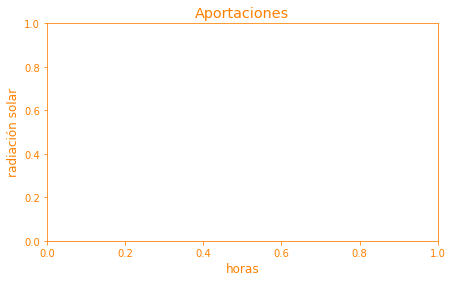

In [288]:
df = pd.read_csv('Aportaciones_Embalses.csv')
apor = df['PEA'].to_numpy()

v = 12             ## tamanio de la ventana (un año)
k = 10             ## número de vecinos a buscar k
vecindario   = []  ## vecindario
vecindario_b = []  ## 
n = len(apor)
distances = list()

for i in range(0,n-2*v):
    #vecindario.append(apor[i:i+v])
    #vecindario_b.append(apor[i+v:i+2*v])
    dist = euclidean(apor[n-v:n],apor[i:i+v] )
    #distances.append((apor[i:i+v], dist))
    distances.append((i, dist))
#neighbors = get_neighbors(vecindario, apor[n-v:n], k)

distances.sort(key=lambda tup: tup[1])
print(distances)

neighbors = []

#aqui esta el error
for pos,dis in distances:
    print(pos)
    #posicion = i[i][0]
    #neighbors.append(apor[i:i+v])
    
print(neighbors)


print_serie(neighbors,'Aportaciones',False,'fig_t13_aportaciones')
#print_serie(neighbors2,'Aportaciones',False,'fig_t13_aportaciones')

# **LVQ**

In [198]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

print('GLVQ')
glvq = GlvqModel(prototypes_per_class=1, initial_prototypes=None)
glvq.fit(X_train,labels)
glvq_pred = glvq.predict(X_test)
glvq_pred_train = glvq.predict(X_train)
print('glvq_pred',glvq_pred)
print('glvq_pred_train', glvq_pred_train)
print('classification accuracy:', (glvq.score(X_test, glvq_pred)))
plt.show()

GLVQ
glvq_pred [6 4 6 9 6 8 9 6 5 0 8 3 2 3 6 8 3 6 8 8 8 5 3 9 0 3 4 4 8 8 8 3 3 9 9 8 5
 3 4 2 4 4 4 8 6 6 1 4 3 3 4 8 3 3 5 2 4 0 3 9 2 0 5 3 1 6 3 6 3 8 1 0 1 3
 4 3 1 4 9 5 0 3 0 7 8 5 8 2 0 5 0 4 3 7 9 6 9 3 4 2 0 9 1 9 3 1 4 3]
glvq_pred_train [6 1 9 7 1 3 3 3 8 7 1 3 3 4 8 3 8 6 8 3 3 6 9 4 0 6 2 3 6 5 6 3 1 1 0 4 3
 4 0 5 3 3 7 4 3 3 9 8 9 9 2 9 9 6 8 6 6 9 9 3 3 9 3 6 0 7 5 9 8 4 1 2 0 8
 7 3 3 1 4 0 1 1 8 4 6 2 0 6 3 7 9 5 3 9 3 4 5 6 0 6 8 8 9 0 3 1 6 9 3 6 3
 5 9 6 8 1 1 3 1 3 5 6 6 6 8 4 6 3 7 8 1 4 1 1 3 1 3 9 7 5 7 1 4 6 7 4 8 4
 5 2 3 9 3 2 4 2 5 8 4 3 3 1 4 0 9 1 9 6 8 1 7 7 8 3 5 5 8 6 1 1 9 4 0 2 2
 4 7 3 4 1 8 7 2 0 3 8 0 6 2 0 4 0 8 6 1 3 9 3 6 4 8 9 5 6 9 4 0 4 4 3 1 8
 9 1 3 6 9 6 6 6 3 2 3 7 1 5 1 8 3 8 3 8 1 5 4 8 3 8 5 4 7 3]
classification accuracy: 1.0


X_train (LVQ)


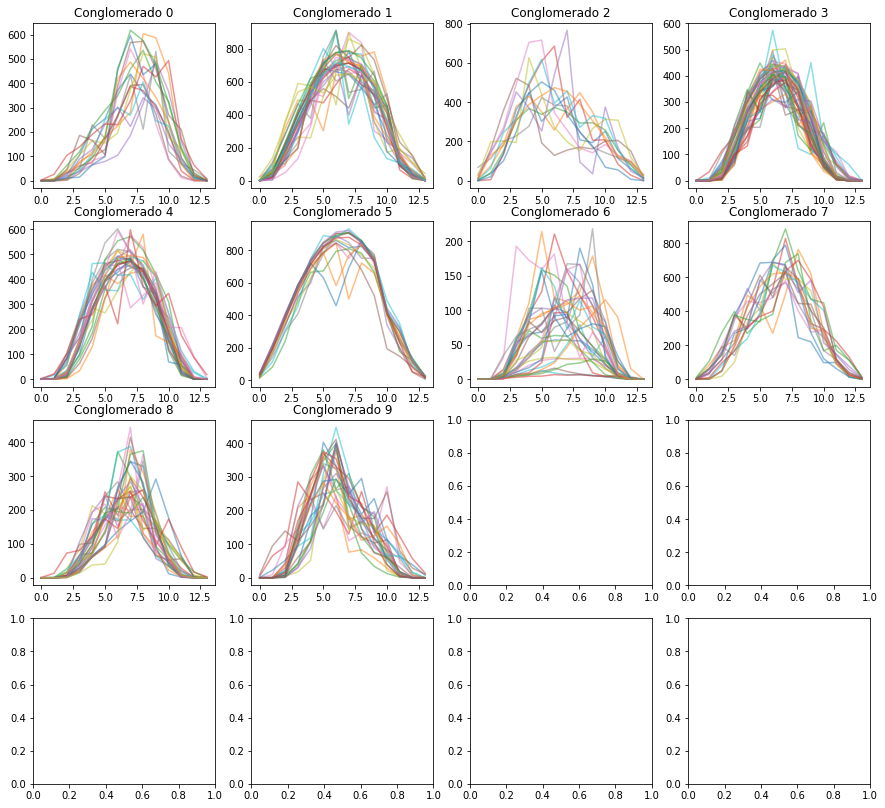

In [199]:
print('X_train (LVQ)')
print_patrones(list_series=X_train,list_categorias=glvq_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_train')

X_test (LVQ)


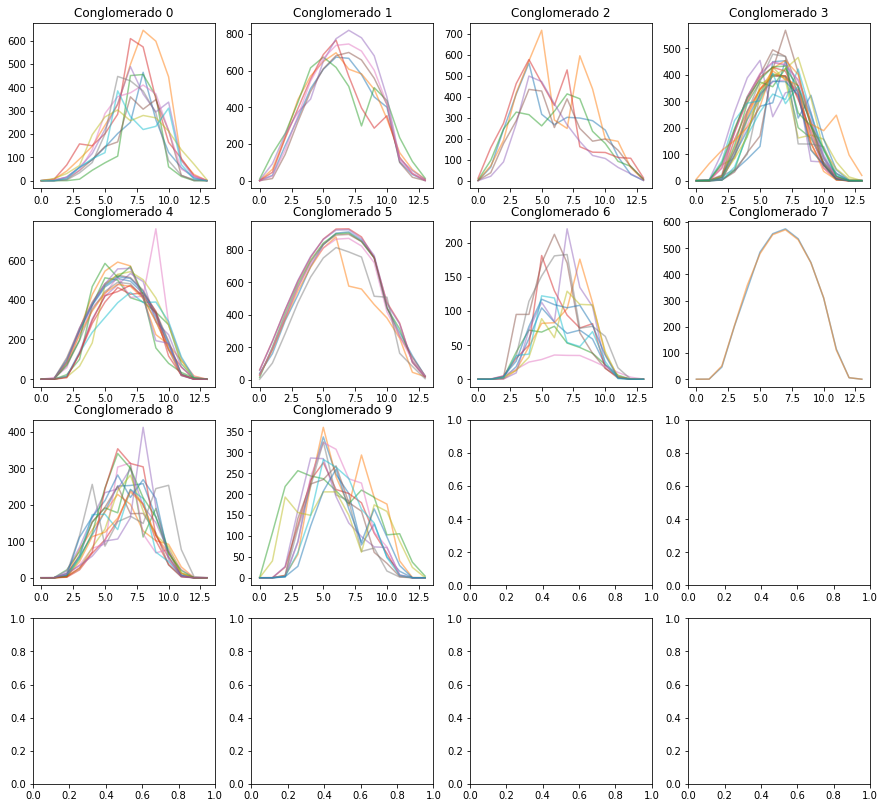

In [200]:
print('X_test (LVQ)')
print_patrones(list_series=X_test,list_categorias=glvq_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_test')

# **GaussianMixture**

In [201]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
gm = GaussianMixture(n_components=n_clusters, init_params='kmeans',covariance_type='full') #full, tied, diag, spherical
gm.fit(X_train)
gm_pred_train = gm.predict(X_train)
gm_pred       = gm.predict(X_test)

print('classification accuracy train:', gm.score(X_train, gm_pred_train))
print('classification accuracy:', gm.score(X_test, gm_pred))

print('gm_pred',gm_pred)
print('gm_pred_train', gm_pred_train)

classification accuracy train: -44.301595153698635
classification accuracy: -78.8305567054598
gm_pred [4 9 4 9 4 9 9 9 2 9 4 9 8 9 9 9 9 9 9 9 9 8 9 8 8 9 9 9 9 9 9 9 9 9 9 9 8
 9 9 8 9 9 8 9 4 4 8 9 9 9 9 9 9 9 2 8 9 9 9 9 8 8 2 9 8 4 9 4 9 9 8 9 8 9
 9 9 8 9 9 2 9 9 8 9 9 2 9 8 9 8 8 9 9 9 9 4 8 9 9 8 9 9 8 9 8 8 9 9]
gm_pred_train [4 8 9 1 8 9 9 9 9 5 8 9 9 9 9 9 9 4 9 9 9 4 9 9 7 4 6 9 4 2 4 9 8 8 7 9 9
 9 7 2 9 9 5 9 9 9 9 9 0 9 6 9 0 4 9 4 4 9 9 9 9 0 9 4 9 5 2 0 0 9 3 6 7 9
 1 9 9 8 9 9 8 8 9 9 4 3 9 4 9 9 9 2 9 9 9 9 2 4 7 4 9 9 9 7 9 8 4 9 9 4 9
 2 0 4 9 8 8 7 3 9 2 4 4 4 7 1 4 9 1 9 8 9 8 8 9 8 9 9 1 2 5 8 1 4 5 9 9 9
 2 6 9 9 9 6 9 6 2 9 9 9 9 8 1 7 4 3 0 4 9 8 1 1 4 9 2 2 9 4 8 8 9 9 7 6 6
 9 8 9 1 8 9 5 6 9 9 0 5 4 6 7 9 9 9 4 3 9 0 7 4 9 9 4 2 9 9 9 5 1 9 9 8 0
 9 8 9 4 9 4 4 4 9 1 9 8 3 2 8 9 9 9 9 9 8 2 9 9 9 9 2 9 1 9]


X_train (GaussianMixture)


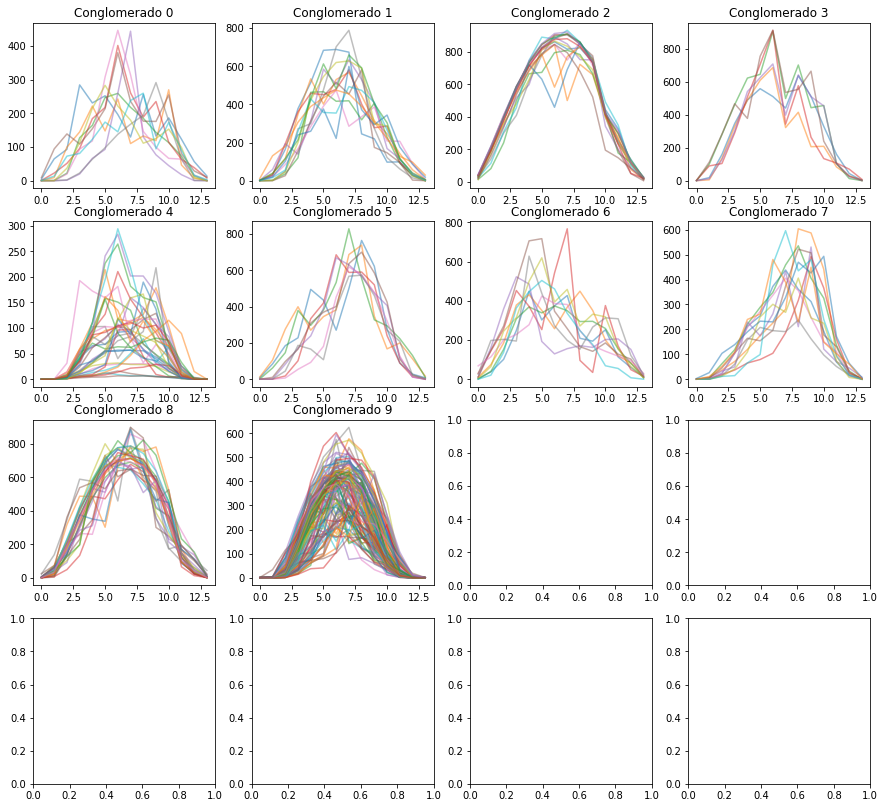

In [202]:
print('X_train (GaussianMixture)')
print_patrones(list_series=X_train,list_categorias=gm_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_train')

X_test (GaussianMixture)


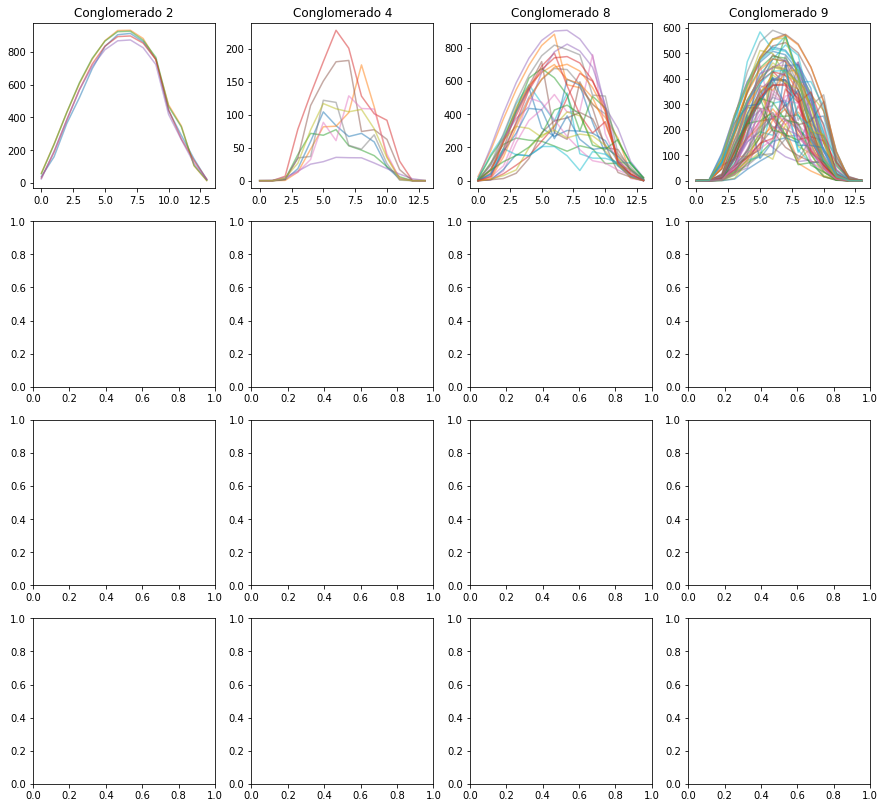

In [203]:
print('X_test (GaussianMixture)')
print_patrones(list_series=X_test,list_categorias=gm_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_test')

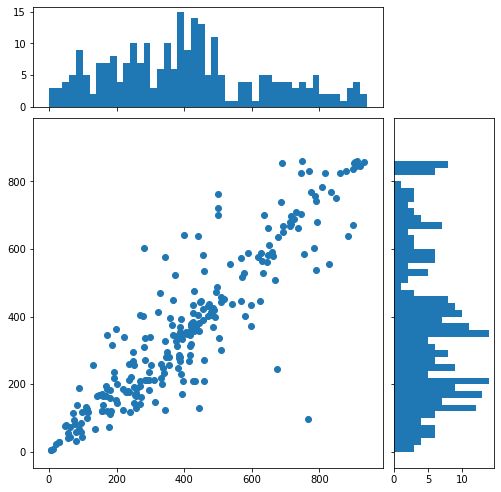

In [204]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    ax.scatter(x, y)
    # now determine nice limits by hand:
    binwidth = 20
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(X_train[:,7],X_train[:,8], ax, ax_histx, ax_histy)

plt.show()

# **KNN**

In [205]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

[[  0.          25.25285462  31.65756009 ...  90.48299103  96.22031001
   98.38157148]
 [  0.          30.23766508  66.47034848 ... 169.19545403 181.14518809
  216.59976404]
 [  0.         115.09253527 140.23439013 ... 177.52999433 186.78924768
  193.48520693]
 ...
 [  0.         213.40765045 226.19709633 ... 255.69324503 259.69787363
  260.5764443 ]
 [  0.         204.87403789 225.14503907 ... 291.26319953 302.01835169
  304.50789356]
 [  0.         106.85252945 155.234287   ... 183.16430845 192.2646989
  196.29986336]] [[  0 203  28 ...  99 229  87]
 [  1 133  10 ... 130 179 132]
 [  2 151  90 ... 137  51 180]
 ...
 [249  89 154 ... 125 215  13]
 [250 171 138 ... 181  70 135]
 [251  27 214 ...  44  20  49]]


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [206]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, labels)
knn_pred_train = knn.predict(X_train)
knn_pred       = knn.predict(X_test)
print('knn_pred', knn_pred)
print('knn_pred_train',knn_pred_train )
print(knn.score(X_test,knn_pred))

knn_pred [6 4 6 9 6 8 9 6 5 8 8 3 2 3 6 8 3 8 8 8 8 1 3 9 0 3 4 4 8 8 8 0 3 9 9 8 5
 3 4 2 4 4 4 8 6 6 1 4 3 3 4 8 3 3 5 2 4 8 3 8 2 0 5 3 1 6 3 6 3 8 1 0 1 3
 4 3 1 4 9 5 8 3 0 4 8 5 8 9 0 1 3 4 3 4 9 6 9 3 4 2 0 8 1 8 4 1 4 3]
knn_pred_train [6 1 9 7 1 3 3 3 8 7 1 3 3 4 8 3 8 6 8 3 3 6 9 4 3 6 3 3 6 5 6 3 1 1 0 4 3
 4 4 5 3 3 7 3 3 3 9 8 9 9 2 9 9 6 8 6 6 8 9 3 3 8 3 6 0 7 1 9 8 4 1 2 0 8
 4 3 3 1 4 8 1 1 8 4 6 4 0 6 3 4 9 5 3 9 3 4 5 6 0 6 8 8 9 0 3 1 6 8 3 6 3
 5 9 6 8 1 1 3 1 3 5 6 6 6 8 4 6 3 4 8 1 3 1 1 3 1 3 9 4 5 7 1 4 6 7 4 8 4
 5 2 3 9 3 2 4 2 5 8 4 3 3 1 4 0 8 1 9 6 8 1 7 4 8 3 5 5 8 6 1 1 9 4 0 3 2
 4 1 3 4 1 3 7 2 0 3 8 0 6 3 0 4 0 8 6 1 3 9 3 6 4 8 8 5 6 9 4 0 4 4 3 1 8
 9 1 3 6 9 6 6 6 3 4 3 1 1 5 1 8 3 8 3 8 1 5 4 8 3 8 1 4 1 3]
1.0


X_train (KNN)


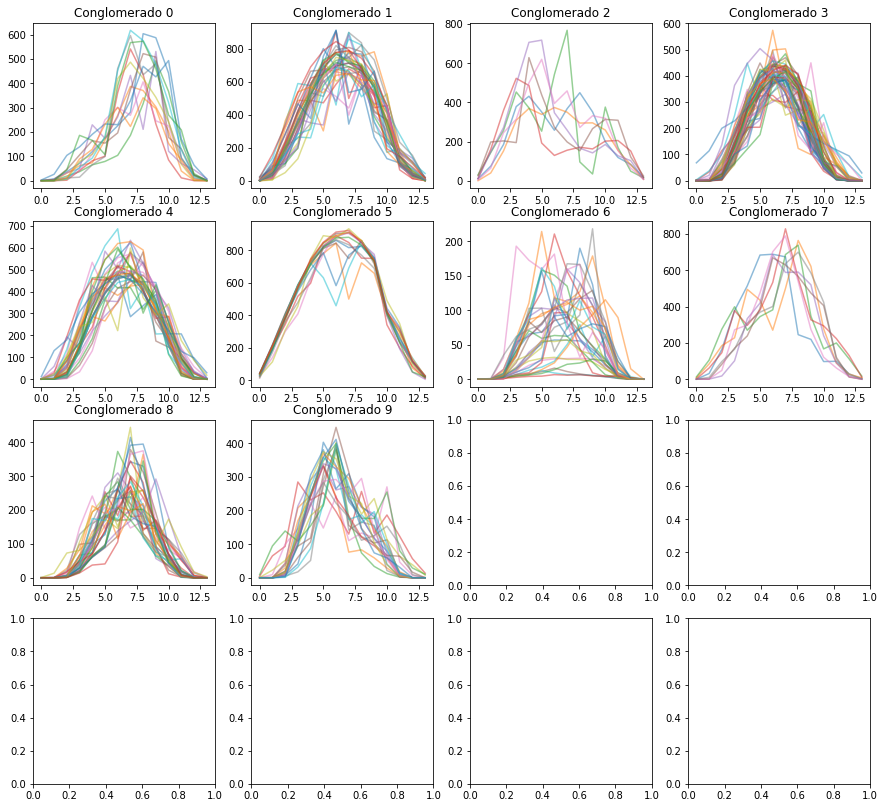

In [207]:
print('X_train (KNN)')
print_patrones(list_series=X_train,list_categorias=knn_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_train')

X_test (KNN)


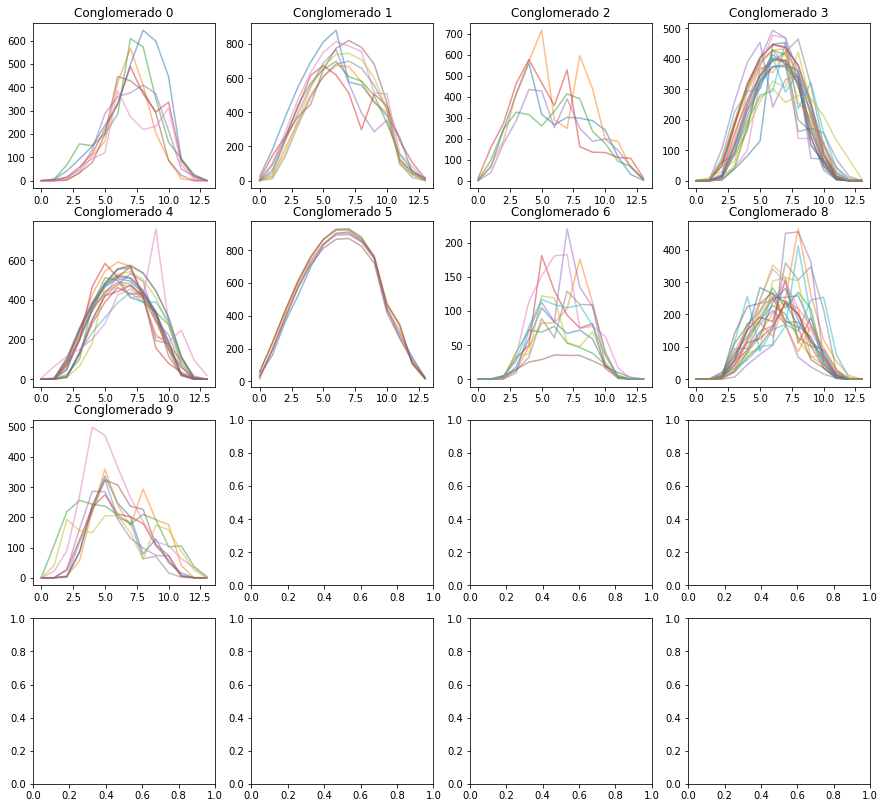

In [208]:
print('X_test (KNN)')
print_patrones(list_series=X_test,list_categorias=knn_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_test')

# **Radiación solar diaria**

In [209]:
#https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/
model=ARIMA(x_total,order=(1,0,1))
model_fit=model.fit()

forecast_dx = model_fit.predict(start=550,end=650,dynamic=False)

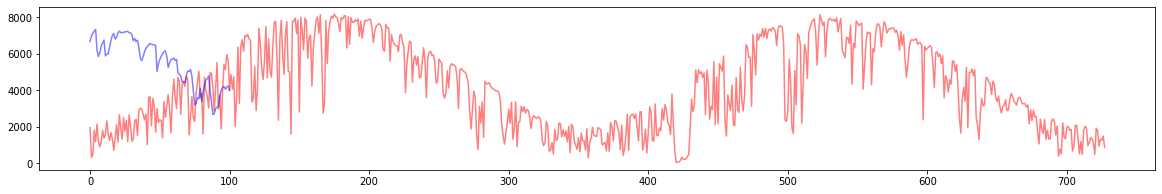

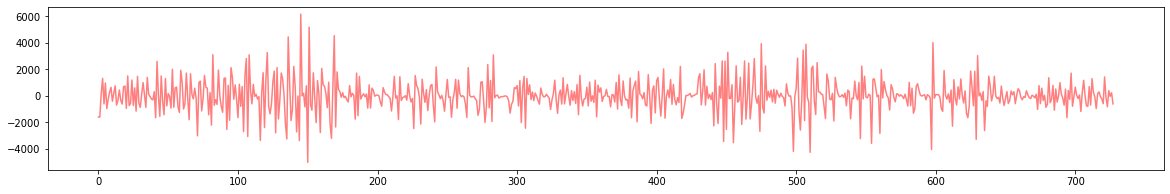

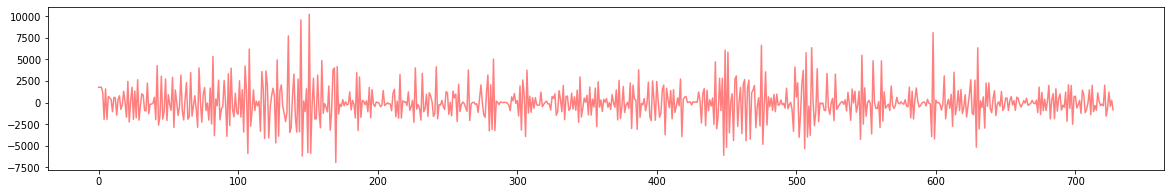

<Figure size 1440x216 with 0 Axes>

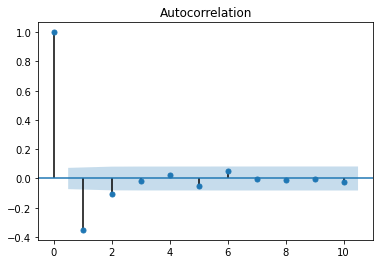

<Figure size 1440x216 with 0 Axes>

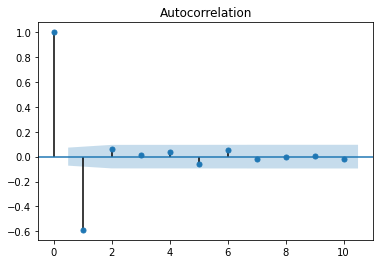

<Figure size 1440x216 with 0 Axes>

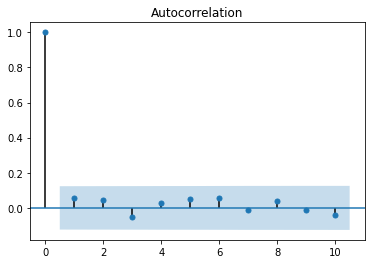

<Figure size 1440x216 with 0 Axes>

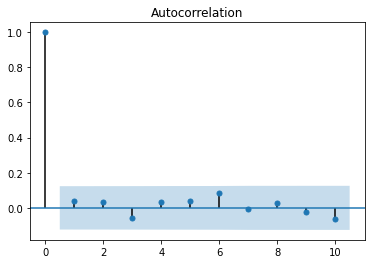

<Figure size 1584x360 with 0 Axes>

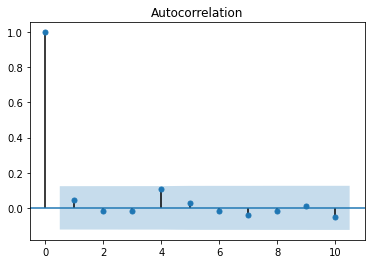

<Figure size 1440x216 with 0 Axes>

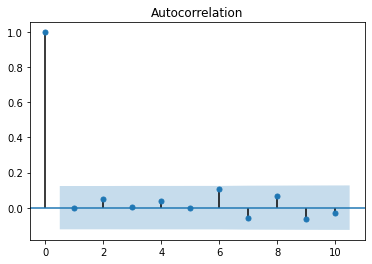

In [210]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=.5,color='red')
plt.plot(forecast_dx,alpha=.5,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=.5,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=.5,color='red')
plt.show()

plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()


plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(y_kmeans_train, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(glvq_pred_train, lags=10)
plt.show()
plt.figure(figsize=(22, 5))
sm.graphics.tsa.plot_acf(gm_pred_train, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(knn_pred_train, lags=10)
plt.show()

In [211]:
model=ARIMA(gm_pred_train  ,order=(1,0,1))
model_fit=model.fit()

forecast_dx = model_fit.predict(start=200,end=300,dynamic=True)
print(forecast_dx)

[6.54393715 6.51763593 6.52018333 6.5199366  6.51996049 6.51995818
 6.5199584  6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838
 6.51995838 6.51995838 6.51995838 6.51995838 6.51995838 6.5199